In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
data_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
dataset = torchvision.datasets.ImageFolder(root='./data/EuroSAT_RGB/', transform=data_transforms)

In [4]:
batch_size = 64
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])

Here I set the train size to 80 percent of the data and test size to 20 percent of the data.

In [5]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


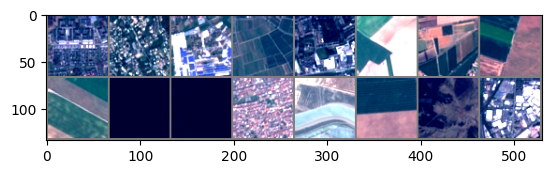

Class Names: Residential Residential Industrial PermanentCrop Industrial AnnualCrop PermanentCrop AnnualCrop AnnualCrop SeaLake SeaLake Residential River AnnualCrop HerbaceousVegetation Industrial Forest HerbaceousVegetation River Industrial SeaLake PermanentCrop Pasture SeaLake River HerbaceousVegetation HerbaceousVegetation Forest SeaLake Pasture SeaLake Forest SeaLake AnnualCrop AnnualCrop AnnualCrop River Pasture Industrial Industrial AnnualCrop River Forest River HerbaceousVegetation Highway Highway Highway PermanentCrop HerbaceousVegetation Pasture Residential Pasture Industrial Forest AnnualCrop Industrial Industrial Industrial SeaLake SeaLake HerbaceousVegetation HerbaceousVegetation River


In [6]:
# Function to display a sample of images
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images and display them
for images, labels in trainloader:
    class_names = [dataset.classes[label] for label in labels]  # Map numerical labels to class names
    imshow(torchvision.utils.make_grid(images[:16]))
    print('Class Names:', ' '.join(class_names))
    break 

This shows an example of images that are in the dataset.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.pool = nn.MaxPool2d(2, 2) 
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(57600, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [9]:
num_epochs = 5


# Main training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):  # Use the subset_trainloader
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        


    # Print average loss for the epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / (i+1)}")

print('Finished Training')

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1, Loss: 1.5052629979051781
Epoch 2, Loss: 0.9519711226753934
Epoch 3, Loss: 0.7558126573026533
Epoch 4, Loss: 0.6227944357508033
Epoch 5, Loss: 0.5343428622688767
Finished Training


Here I run the training loop with 5 epochs and the loss decreases every time.

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for test_images, test_labels in testloader:  
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = net(test_images)
        _, predicted = torch.max(test_outputs, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

accuracy = correct / total
print('Test-set Accuracy:', accuracy)

Test-set Accuracy: 0.7742592592592593


I get the test accuracy by going through the test set and I predict each of them. Then the accuracy is calculated by dividing the ones that are correct by the total.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


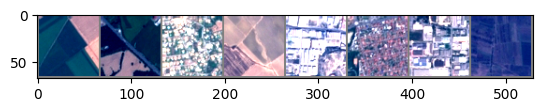

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Predicted: AnnualCrop Highway PermanentCrop PermanentCrop Industrial Residential Industrial HerbaceousVegetation


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


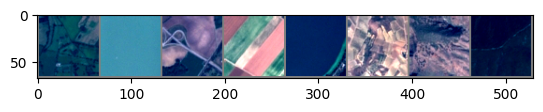

Predicted: Pasture SeaLake Highway AnnualCrop SeaLake PermanentCrop HerbaceousVegetation Forest


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


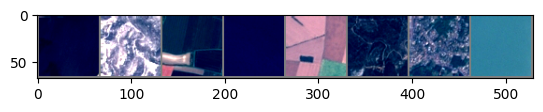

Predicted: Forest Residential Pasture SeaLake AnnualCrop HerbaceousVegetation Residential SeaLake


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


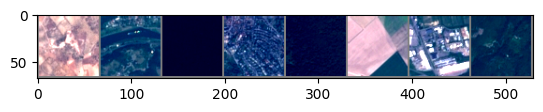

Predicted: PermanentCrop Residential SeaLake Residential Forest AnnualCrop Industrial Forest


In [12]:
count = 0
for test_images, test_labels in testloader:  # Use the subset_testloader
    count +=1
    test_images, test_labels = test_images.to(device), test_labels.to(device)
    if count %20 == 0:
        imshow(torchvision.utils.make_grid(test_images[:8].cpu()))
        test_outputs = net(test_images[:8])
        _, predicted = torch.max(test_outputs, 1)

        # Map numerical labels to class names
        predicted_classes = [dataset.classes[p] for p in predicted]
        print('Predicted:', ' '.join(predicted_classes))

Here are some examples of images from the test set and the predictions under that.

C:\Users\david\AppData\Roaming\Python\Python311\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


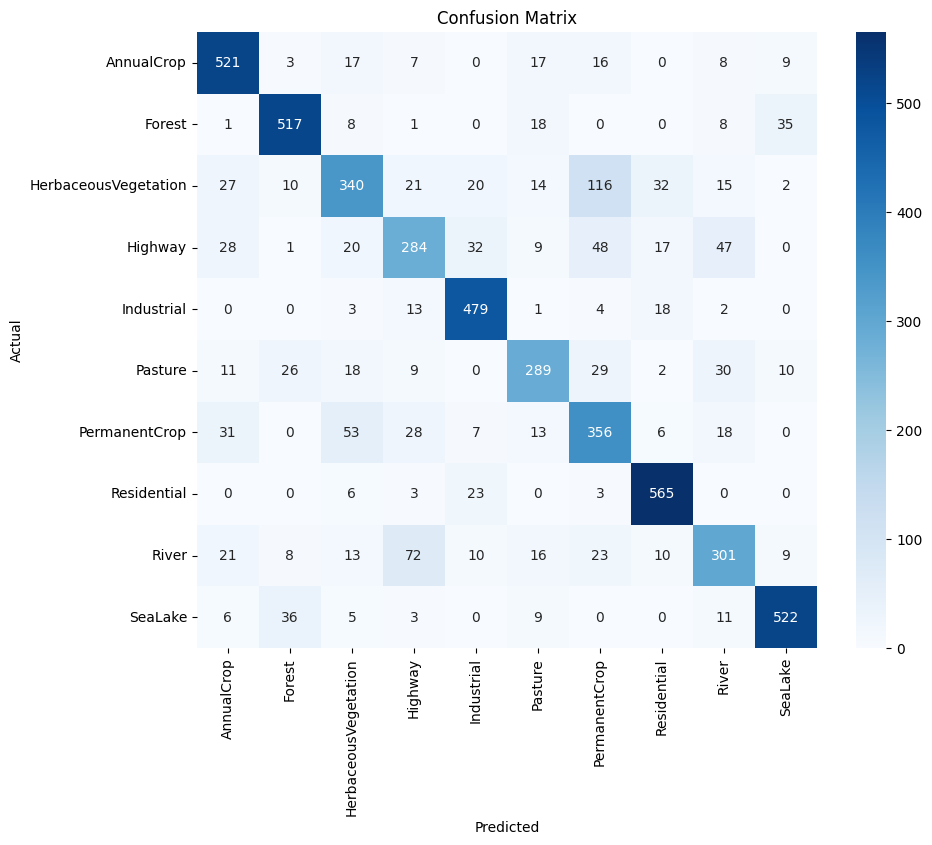

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

actual_labels = []
predicted_labels = []

with torch.no_grad():
    for test_images, test_labels in testloader:
        test_images, test_labels = test_images.to(device), test_labels.to(device)
        test_outputs = net(test_images)
        _, predicted = torch.max(test_outputs, 1)
        actual_labels.extend(test_labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(actual_labels, predicted_labels)

# Display the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

I printed a confusion matrix each type of image. The one that was predicted correctly the most was Residential. Others that had a lot of correct predictions were SeaLake, Annual Crop, and Forest. The one that was predicted the most incorrectly were Permanent Crop and Herbaceous Vegetation. This makes sense as they are very similar types of images.